In [1]:
import pandas as pd
df = pd.read_csv('Nat_Gas.csv')
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
df
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df = df.sort_values(by='Dates') #or
df.set_index ("Dates" , inplace= True)

**Let's visualize the time series data now and try to understand**

<Axes: xlabel='Dates'>

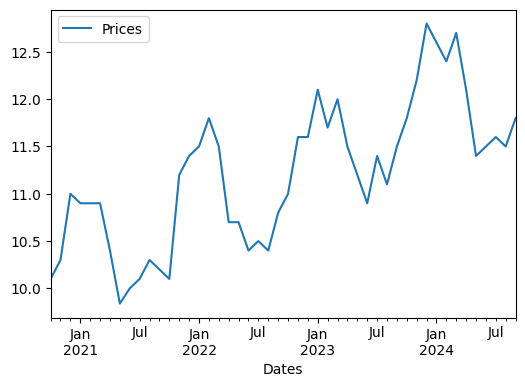

In [4]:
df.plot(figsize=(6,4))

**Lets do some statistical modelling**

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Prices,48.0,11.207083,0.757897,9.84,10.65,11.3,11.625,12.8


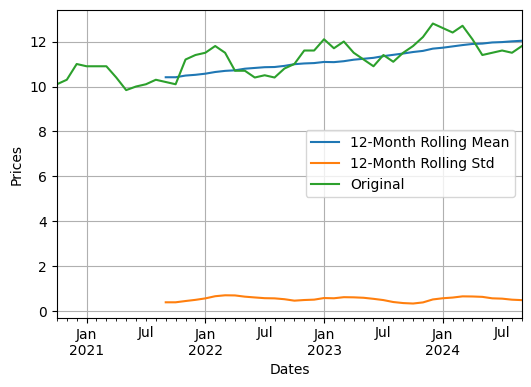

In [8]:
time_series = df['Prices']
type(time_series)
time_series.rolling(12).mean().plot(figsize=(6,4), label='12-Month Rolling Mean')
time_series.rolling(12).std().plot(figsize=(6,4), label='12-Month Rolling Std')
time_series.plot(label='Original')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()

Check if it's stationary

Let's do some decompositions and ACF and PACF

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

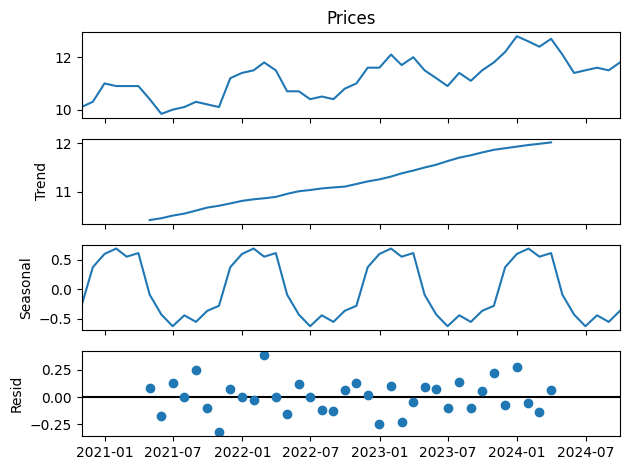

In [19]:
decomp = seasonal_decompose(time_series)
decomp.plot()
plt.show()

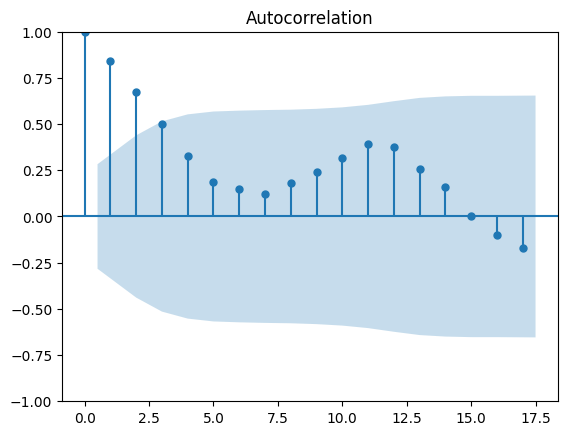

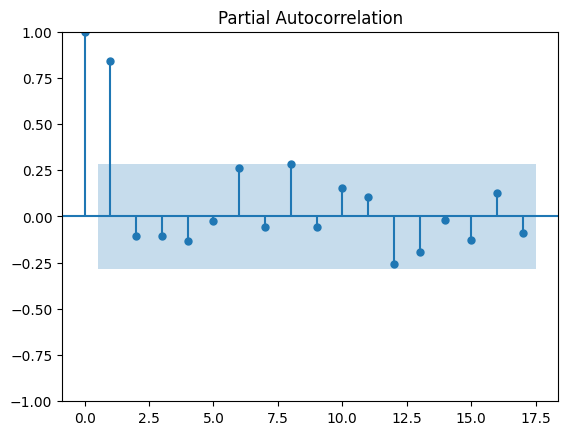

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(time_series)
plot_pacf(time_series)
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(time_series)
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.21807686169999427
p-value: 0.973257438844869
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [140]:
#build a func. to easily check stationarity
def test_stationarity(time_series_data):
    decomp = seasonal_decompose(time_series_data)
    decomp.plot()
    plt.show()
    adf_test = adfuller(time_series_data)
    print('ADF Statistic:', adf_test[0])
    print('p-value:', adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

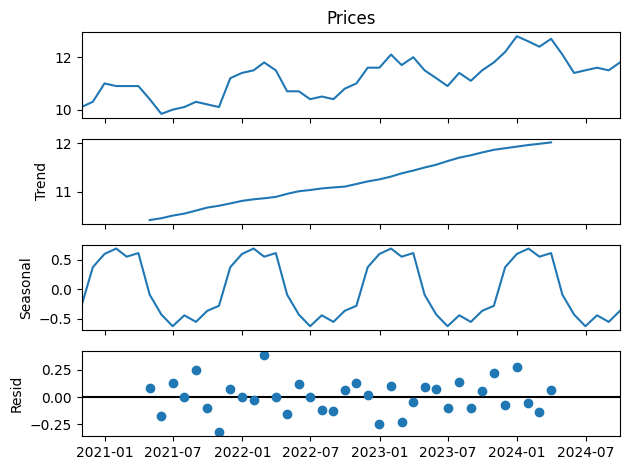

ADF Statistic: 0.21807686169999427
p-value: 0.973257438844869
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [141]:
df.head()
test_stationarity(time_series)

Perform first-order differencing
To stationarize

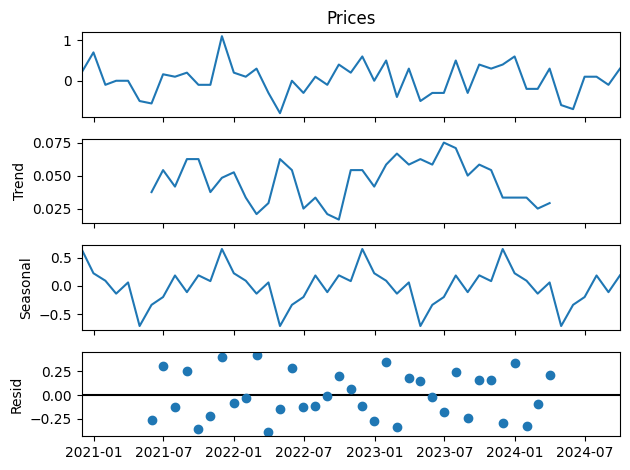

ADF Statistic: -6.844773557477344
p-value: 1.754169685294091e-09
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [40]:
time_series_diff = time_series.diff().dropna()
test_stationarity(time_series_diff)

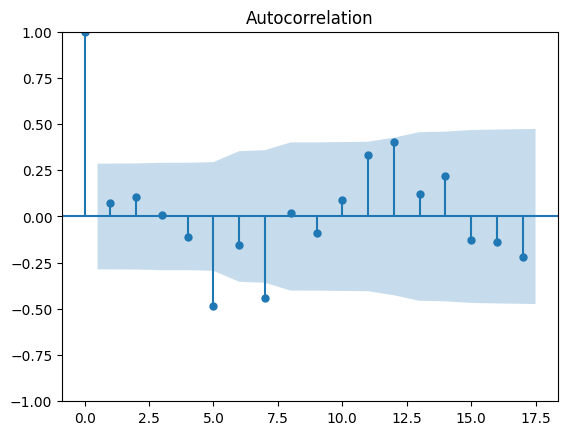

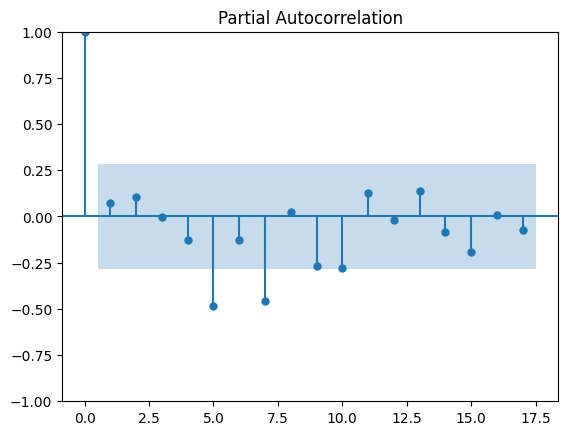

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(time_series_diff)
plot_pacf(time_series_diff)
plt.show()

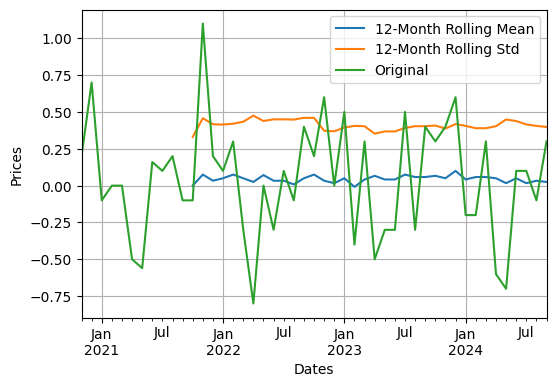

In [44]:
time_series_diff.rolling(12).mean().plot(figsize=(6,4), label='12-Month Rolling Mean')
time_series_diff.rolling(12).std().plot(figsize=(6,4), label='12-Month Rolling Std')
time_series_diff.plot(label='Original')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()

Now that it's stationary let's do the ARIMA model fit

In [54]:
from statsmodels.tsa.arima.model import ARIMA

Using seasonal ARIMA model, seasonal ARIMA model, diffrencing handled inside

In [176]:
model = sm.tsa.statespace.SARIMAX(time_series, order=(0, 1, 0), seasonal_order=(1, 0, 0, 12))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [177]:
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 -16.957
Date:                            Mon, 13 Oct 2025   AIC                             37.914
Time:                                    03:55:15   BIC                             41.615
Sample:                                10-31-2020   HQIC                            39.307
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4892      0.187      2.614      0.009       0.122       0.856
sigma2         0.1123      0.024   

<Axes: xlabel='Dates'>

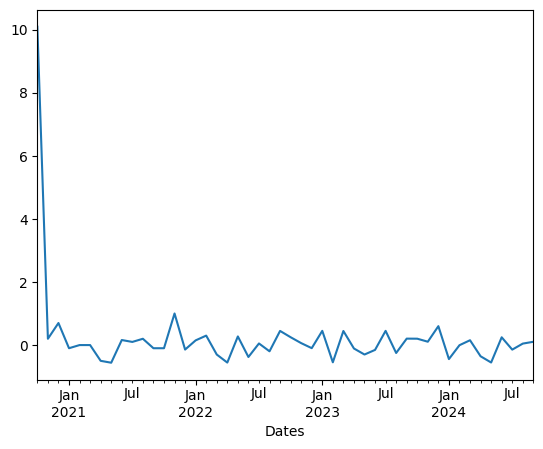

In [178]:
results.resid.plot() #residual error points

<Axes: ylabel='Density'>

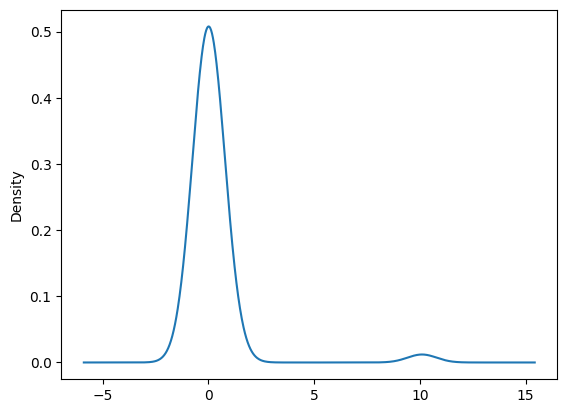

In [179]:
results.resid.plot(kind='kde') #kernel density estimation

Residuals around zero and KDE normally distributed around zero suggest a good fit

Now forecasting

<Axes: xlabel='Dates'>

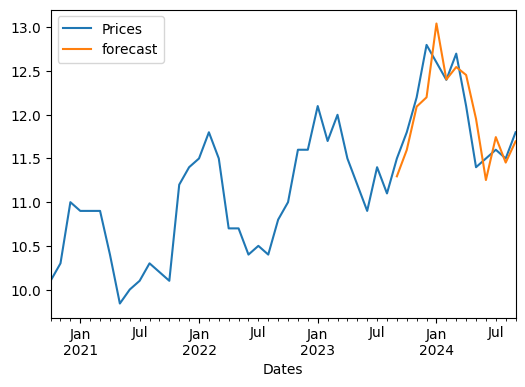

In [180]:
df['forecast'] = results.predict(start=35, end = 48)
df[['Prices', 'forecast']].plot(figsize=(6, 4))

Future 1 year forecasting:

In [181]:
df.tail()

,Prices,forecast
Dates,,
2024-05-31,11.4,11.953233
2024-06-30,11.5,11.253233
2024-07-31,11.6,11.744612
2024-08-31,11.5,11.453233
2024-09-30,11.8,11.695689


In [182]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 24)]
future_dates

[Timestamp('2024-10-30 00:00:00'),
 Timestamp('2024-11-30 00:00:00'),
 Timestamp('2024-12-30 00:00:00'),
 Timestamp('2025-01-30 00:00:00'),
 Timestamp('2025-02-28 00:00:00'),
 Timestamp('2025-03-30 00:00:00'),
 Timestamp('2025-04-30 00:00:00'),
 Timestamp('2025-05-30 00:00:00'),
 Timestamp('2025-06-30 00:00:00'),
 Timestamp('2025-07-30 00:00:00'),
 Timestamp('2025-08-30 00:00:00'),
 Timestamp('2025-09-30 00:00:00'),
 Timestamp('2025-10-30 00:00:00'),
 Timestamp('2025-11-30 00:00:00'),
 Timestamp('2025-12-30 00:00:00'),
 Timestamp('2026-01-30 00:00:00'),
 Timestamp('2026-02-28 00:00:00'),
 Timestamp('2026-03-30 00:00:00'),
 Timestamp('2026-04-30 00:00:00'),
 Timestamp('2026-05-30 00:00:00'),
 Timestamp('2026-06-30 00:00:00'),
 Timestamp('2026-07-30 00:00:00'),
 Timestamp('2026-08-30 00:00:00')]

In [183]:
future_df = pd.DataFrame(index = future_dates, columns = df.columns)
future_df

,Prices,forecast
2024-10-30,NaN,NaN
2024-11-30,NaN,NaN
2024-12-30,NaN,NaN
2025-01-30,NaN,NaN
2025-02-28,NaN,NaN
2025-03-30,NaN,NaN
2025-04-30,NaN,NaN
2025-05-30,NaN,NaN
2025-06-30,NaN,NaN
2025-07-30,NaN,NaN


In [184]:
final_df = pd.concat([df, future_df])
final_df

/tmp/ipython-input-1805618351.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([df, future_df])


,Prices,forecast
2020-10-31,10.1,NaN
2020-11-30,10.3,NaN
2020-12-31,11.0,NaN
2021-01-31,10.9,NaN
2021-02-28,10.9,NaN
...,...,...
2026-04-30,NaN,NaN
2026-05-30,NaN,NaN
2026-06-30,NaN,NaN
2026-07-30,NaN,NaN


In [185]:
forecast = results.predict(start=48, end=70)
forecast.index = final_df.index[-len(forecast):]  # align indexes
final_df["forecast"] = forecast
final_df

,Prices,forecast
2020-10-31,10.1,NaN
2020-11-30,10.3,NaN
2020-12-31,11.0,NaN
2021-01-31,10.9,NaN
2021-02-28,10.9,NaN
...,...,...
2026-04-30,NaN,12.090371
2026-05-30,NaN,11.922833
2026-06-30,NaN,11.946767
2026-07-30,NaN,11.970701


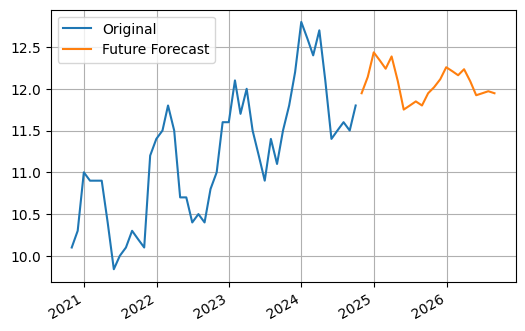

In [186]:
final_df['Prices'].plot(figsize=(6, 4), label = 'Original' )
final_df['forecast'].plot(figsize=(6, 4), label = 'Future Forecast')
plt.legend()
plt.grid(True)
plt.show()

retrieving rices directly from the final_df

In [188]:
def get_price(input_date_str, dataframe=final_df):
    try:
        input_date = pd.to_datetime(input_date_str)
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."

    try:
        if input_date in dataframe.index:
            if pd.notna(dataframe.loc[input_date, 'Prices']):
                return dataframe.loc[input_date, 'Prices']
            elif pd.notna(dataframe.loc[input_date, 'forecast']):
                return dataframe.loc[input_date, 'forecast']
            else:
                return f"No price or forecast available for {input_date_str} in the DataFrame."
        else:
            return f"Date {input_date_str} not found in the DataFrame index."

    except Exception as e:
        return f"An error occurred while retrieving the price: {e}"

In [189]:
get_price("2030-01-01", dataframe=final_df) #date_not_in_df

'Date 2030-01-01 not found in the DataFrame index.'

In [190]:
get_price("2025-06-30", dataframe=final_df) #date_to_retrieve_forecast

np.float64(11.8)